(dask_for_arviz)=
# Dask for ArviZ

## Dask overview

Dask is a _big data processing_ library used for:
1. _Parallelizing_ the computation of the workflow consisting of NumPy, pandas, xarray and scikit-learn frameworks.
2. _Scaling_ the workflows up or down depending upon the hardware that is being used.

Most notably, it provides the support for working with _larger-than-memory_ datasets. In this case, dask partitions the dataset into smaller chunks, then loads only a few chunks from the disk, and once the necessary processing is completed, it throws away the intermediate values. This way, the computations are performed without exceeding the memory limit.

---

Check out these links if you're unsure whether your workflow can benefit from using Dask or not:
- {doc}`dask:why`
- {doc}`dask:array-best-practices`

Excerpt from "Dask Array Best Practices" doc.
>If your data fits comfortably in RAM and you are not performance bound, then using `NumPy` might be the right choice. Dask adds another layer of complexity which may get in the way.
>
>If you are just looking for speedups rather than scalability then you may want to consider a project like `Numba`.

---

:::{caution}
Dask is an optional dependency inside ArviZ, which is still being **actively developed**. Currently, few functions belonging to **diagnostics** and **stats** module can utilize Dask's capabilities. 
:::

In [1]:
import arviz as az
import numpy as np
import timeit
import dask

from arviz.utils import conditional_jit, Dask

In [2]:
# optional imports
from dask.distributed import Client
from dask.diagnostics import ResourceProfiler

from bokeh.resources import INLINE
import bokeh.io
bokeh.io.output_notebook(INLINE)

%reload_ext memory_profiler

Loading BokehJS ...

:::{note}
{func}`~dask.diagnostics.ResourceProfiler` and {class}`~distributed.Client` are optional. They are only used for the visualizing and profiling the dask enabled methods. ArviZ-Dask integration can be used without using these objects.
:::

In [3]:
client = Client(threads_per_worker=4, n_workers=1, memory_limit="1.2GB")
client

<Client: 'tcp://127.0.0.1:35215' processes=1 threads=4, memory=1.12 GiB>

### Variance example

In [4]:
array_size = 250_000_000

Calculating variance using `Numpy`

In [5]:
%%memit 
data = np.random.randn(array_size)
np.var(data, ddof=1)
del data

peak memory: 4072.28 MiB, increment: 3815.28 MiB


Calculating variance using Dask arrays:
- Divides the array into multiple chunks.
- Objects are lazy in nature and are computed on-the-fly.
- Builds a task graph of the entire computation and parallelizes the execution. 



In [6]:
%memit data = dask.array.random.normal(size=array_size, chunks="auto")
data

peak memory: 258.30 MiB, increment: 0.28 MiB


dask.array<normal, shape=(250000000,), dtype=float64, chunksize=(15625000,), chunktype=numpy.ndarray>

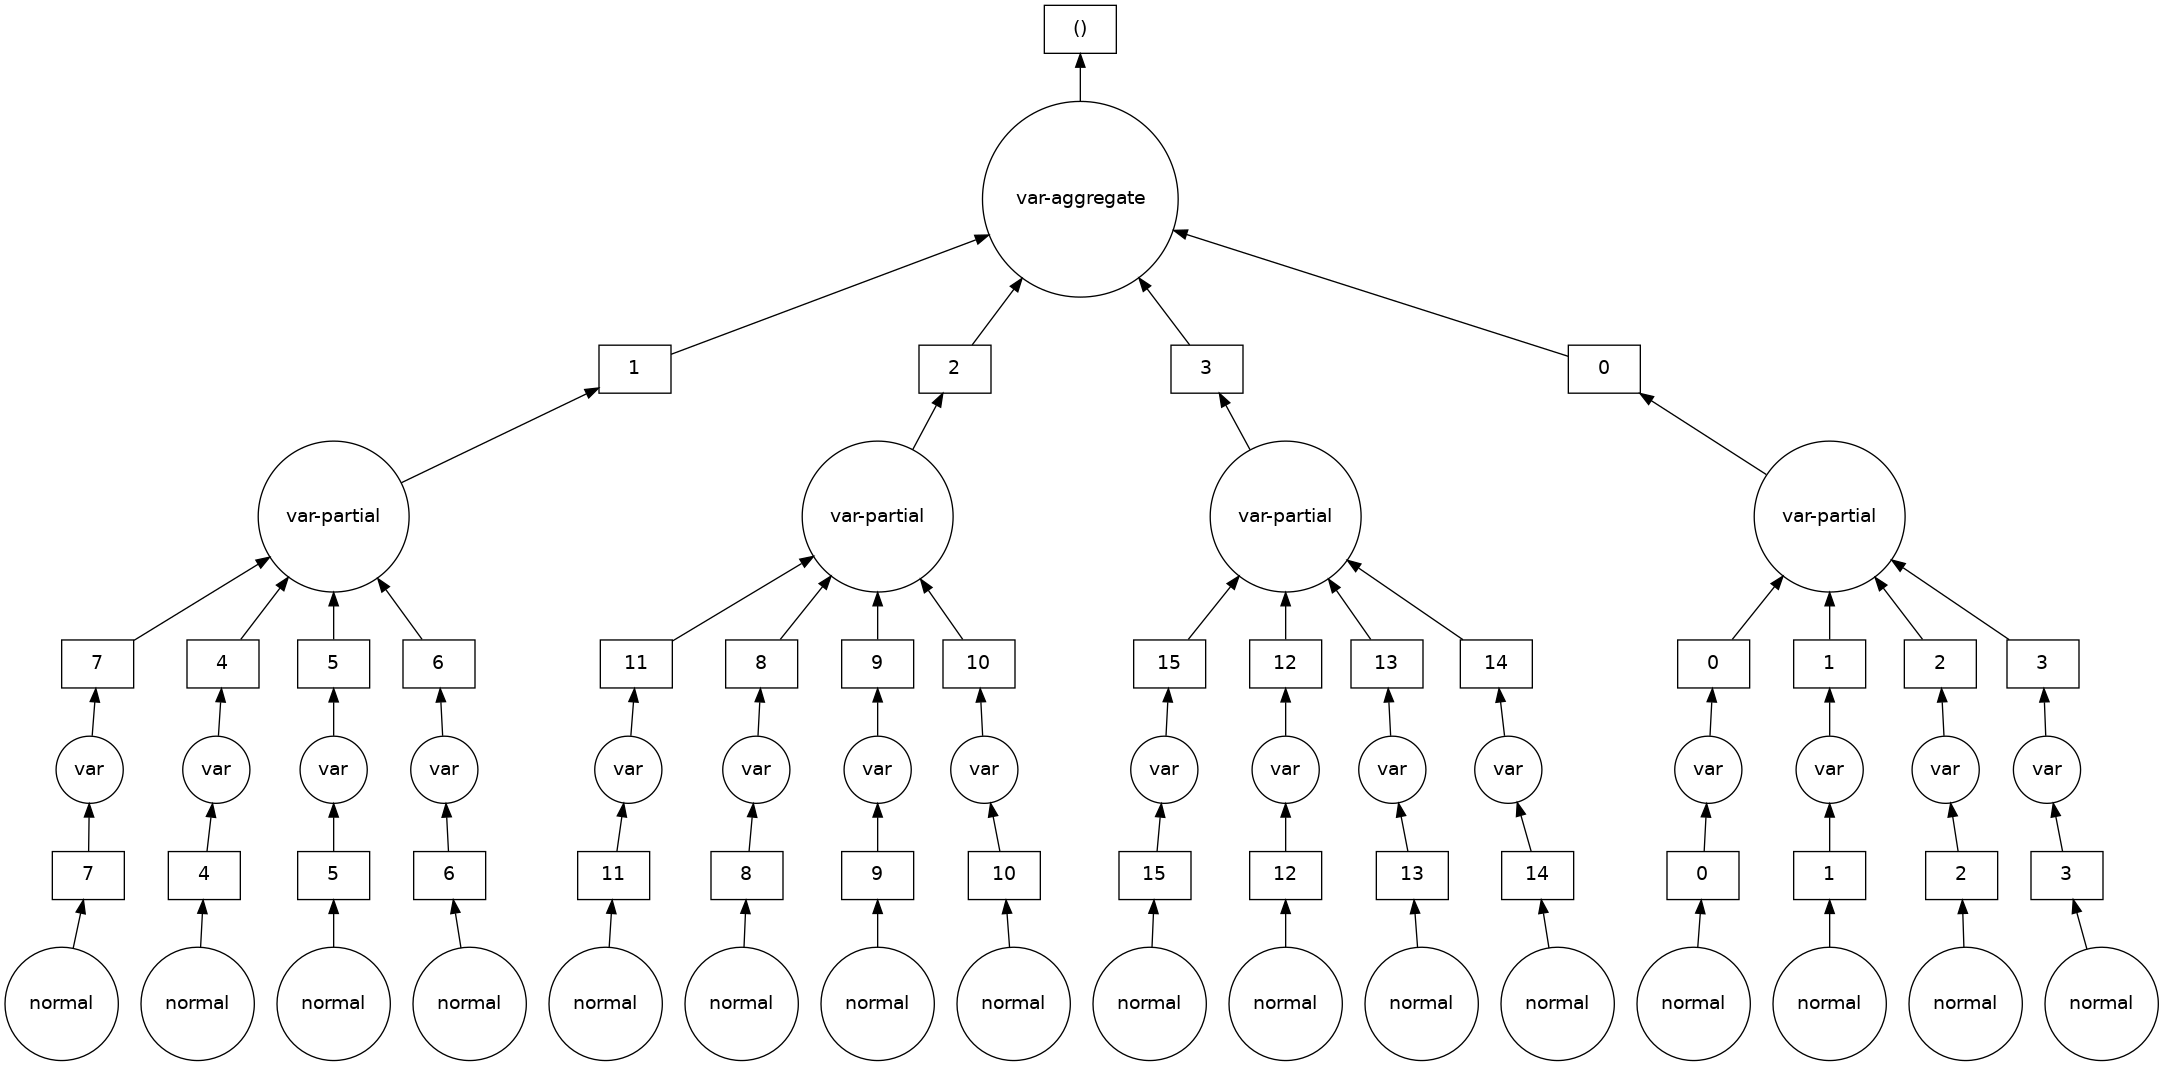

In [7]:
var = dask.array.var(data, ddof=1)
var.visualize()

In [8]:
with ResourceProfiler(dt=0.25) as rprof:
    var.compute()

rprof.visualize();

In [9]:
del data

Here, the `NumPy` version consumed around ~5GB memory but the Dask version was able to compute variance in under 1.2Gb memory (the limit set in the `Client` configuration above) which shows how beneficial Dask can be when dealing with large datasets.

## ArviZ-Dask integration
### Creating Dask-backed InferenceData objects

`InferenceData` is the central data format for ArviZ and there are several ways to generate this object (which you can look {ref}`here<creating_InferenceData>`. 

However, as the ArviZ-Dask integraton is still a work in progress, to use `InferenceData` object with Dask-compatible methods we'll have generate it in a different way. {func}`arviz.from_netcdf` has an experimental `group_kwargs` argument that can be used to read netCDF files directly with Dask. 

We will progressively add more ways to generate Dask backed `InferenceData` and document them here. If you are interested in helping out, reach out on [Gitter](https://gitter.im/arviz-devs/community)

#### From dictionary using `dask.array`

We start creating a dask array with random samples, that we can then convert to `InferenceData` using {func}`arviz.from_dict`. ArviZ passes values and coord values as is to xarray, so by passing a dask array we'll get a dask backed InferenceData automatically.

In [10]:
%memit daskdata = dask.array.random.random((10, 1000, 10000), chunks=(10, 1000, 625))
daskdata

peak memory: 260.43 MiB, increment: 0.07 MiB


dask.array<random_sample, shape=(10, 1000, 10000), dtype=float64, chunksize=(10, 1000, 625), chunktype=numpy.ndarray>

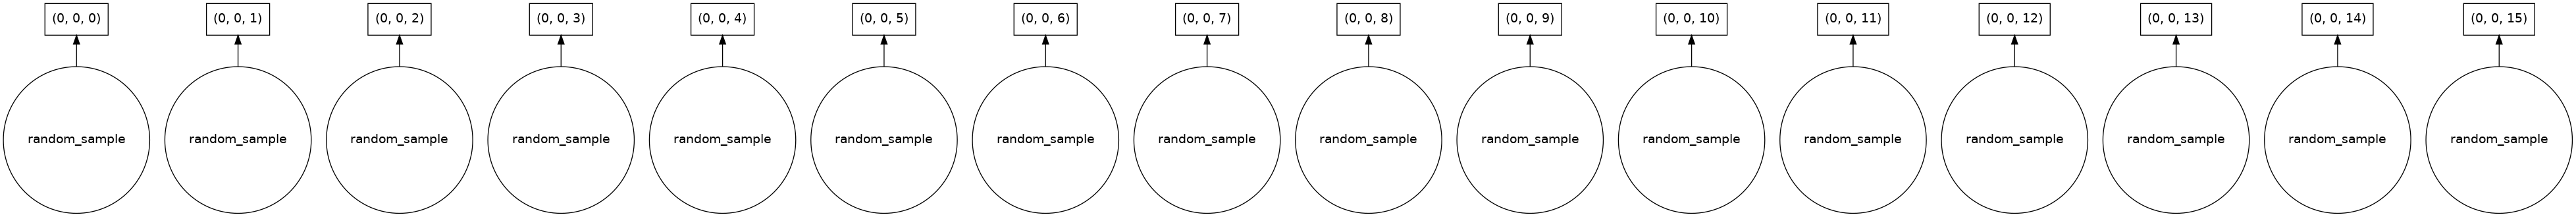

In [11]:
daskdata.visualize() # Each chunk will follow lazy evaluation 

:::{note}
Setting up the right value of the chunks parameter is very important. Computation on Dask arrays with small chunks are slow because each operation on a chunk has some overhead. On the other side, if your chunks are too big, then it might not fit in the memory. 
:::

In [12]:
datadict = {"x": daskdata}
%memit idata_dask = az.from_dict(posterior=datadict, dims={"x": ["dim_1"]})
idata_dask

peak memory: 260.55 MiB, increment: 0.07 MiB


Inference data with groups:
	> posterior

### Executing ArviZ functions with Dask

{class}`arviz.Dask` provides the functionality of disabling/re-enabling Dask. This is an ArviZ specific class that therefore works only with ArviZ functions that support computation via Dask.

We can also use it to set default arguments which are then taken by the Dask supporting functions and passed to {func}`xarray.apply_ufunc`. 

For comparison lets first create an `InferenceData` object using `numpy` array

In [13]:
%memit npdata = np.random.rand(10, 1000, 10000)
datadict = {"x": npdata}
idata_numpy = az.from_dict(posterior=datadict, dims={"x": ["dim_1"]})
idata_numpy

peak memory: 1023.65 MiB, increment: 762.97 MiB


Inference data with groups:
	> posterior

#### `arviz.ess` 

In [14]:
%%time
%%memit

az.ess(idata_numpy)

peak memory: 1034.65 MiB, increment: 10.89 MiB
CPU times: user 21 s, sys: 192 ms, total: 21.2 s
Wall time: 21 s


:::{tip}
Set the most common default dask_kwargs when enabling Dask in order to simplify
future function calls. If needed, those default kwargs can always be overrriden
with the function specific `dask_kwargs` argument.
:::

In [15]:
Dask.enable_dask(dask_kwargs={"dask": "parallelized", "output_dtypes": [float]})

In [16]:
%%time
%%memit

ess = az.ess(idata_dask)

with ResourceProfiler(dt=0.25) as rprof:
    ess.compute()

peak memory: 1035.45 MiB, increment: 0.79 MiB
CPU times: user 643 ms, sys: 104 ms, total: 747 ms
Wall time: 15.8 s


Each chunk also contains the evaluation expression which will be calculated in parallel and on-the-fly 

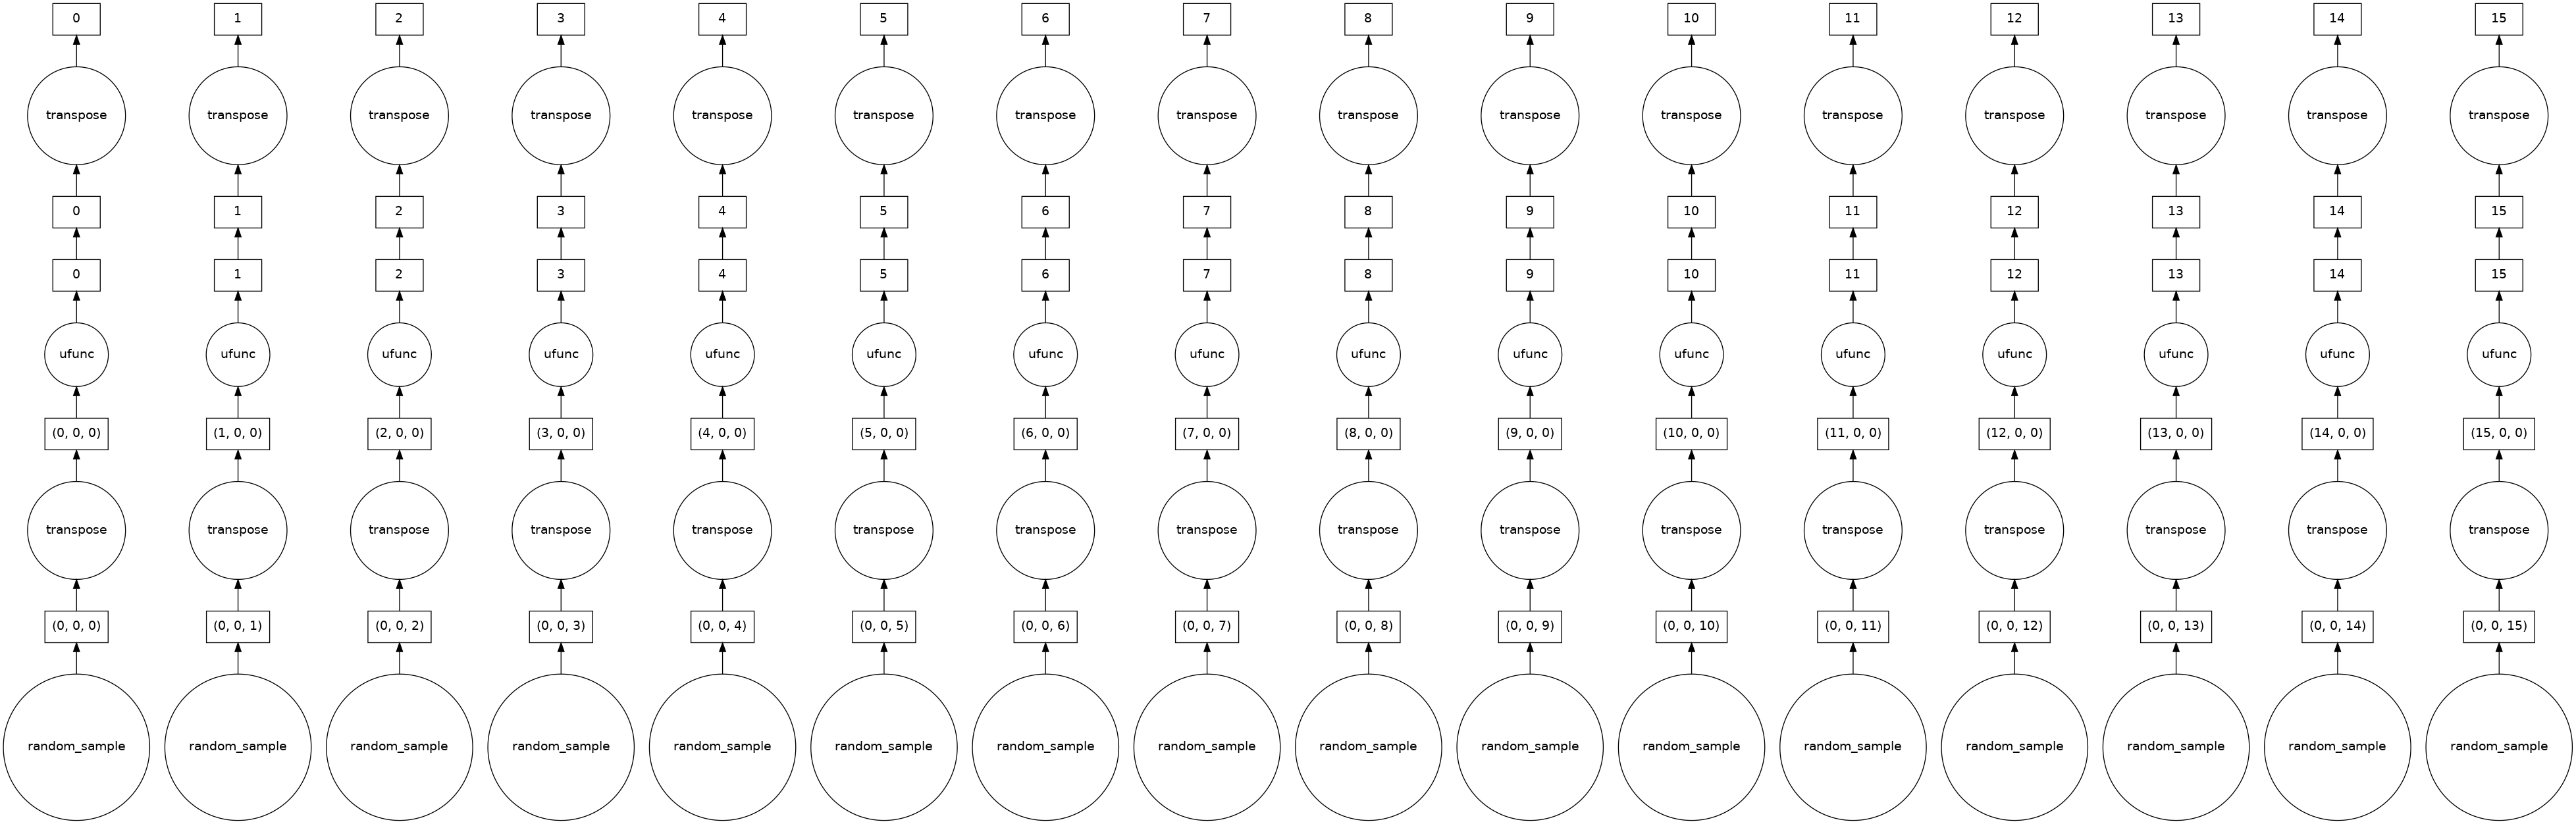

In [17]:
ess.data_vars["x"].data.visualize()

In [18]:
rprof.visualize()
Dask.disable_dask()

Here, dask enabled method consumed around ~400MB memory which is around ~360MB lesser than the vanilla method (also considering the memory consumption of the `Numpy` Array ). Dask enabled method is also a bit faster.

#### `arviz.rhat `

In [19]:
%%time
%%memit

az.rhat(idata_numpy)

peak memory: 1035.81 MiB, increment: 0.30 MiB
CPU times: user 32.7 s, sys: 167 ms, total: 32.9 s
Wall time: 32.5 s


In [20]:
Dask.enable_dask(dask_kwargs={"dask": "parallelized", "output_dtypes": [int]})

We have now enabled Dask with incorrect default kwargs, which we have to override in the function call:

In [21]:
%%time
%%memit

rhat =  az.rhat(idata_dask, dask_kwargs={"output_dtypes": [float]})

with ResourceProfiler(dt=0.25) as rprof:
    rhat.compute()

peak memory: 1036.70 MiB, increment: 0.88 MiB
CPU times: user 709 ms, sys: 156 ms, total: 865 ms
Wall time: 20.6 s


In [22]:
rprof.visualize()
Dask.disable_dask()

#### `arviz.hdi`

In [23]:
%%time
%%memit

az.hdi(idata_numpy, hdi_prob=.68)

peak memory: 1037.05 MiB, increment: 0.20 MiB
CPU times: user 5.9 s, sys: 63.8 ms, total: 5.96 s
Wall time: 5.95 s


In [24]:
Dask.enable_dask(dask_kwargs={"dask": "parallelized", "output_dtypes": [float]})

With {func}`arviz.hdi` we are introducing a new dimension to the output, the one containing the lower and higher HDI limits, so we need to use `dask_gufunc_kwargs` from {func}`xarray.apply_ufunc` which is passed as `**kwargs` first to {func}`arviz.wrap_xarray_ufunc`, then to {func}`xarray.apply_ufunc`.

In [25]:
%%time
%%memit

hdi = az.hdi(idata_dask, hdi_prob=0.68, dask_gufunc_kwargs={"output_sizes": {"hdi": 2}})

with ResourceProfiler(dt=0.25) as rprof:
    hdi.compute()

peak memory: 1037.55 MiB, increment: 0.50 MiB
CPU times: user 266 ms, sys: 78.1 ms, total: 344 ms
Wall time: 2.78 s


In [26]:
rprof.visualize()
Dask.disable_dask()
client.close()

**In all the examples, it's noticeable that:**
1. Data structures provided by dask reduces the overall memory footprint, as it divides them into multiple chunks.
2. Due to the breakdown of complex computations into small tasks and parallelizing the executions, dask supported methods achieve significant performance gain.